# Dependencies

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Globals

In [2]:
m = 0.5
d = 0.2
beta0 = 190
beta1 = 5
beta2 = 0
b = 280
g = 9.8
Ix = 0.003
Iy = 0.003
Iz = 0.007
Kfax = 0.0005
Kfay = 0.0005
Kfaz = 0.0006
Kftx = 0.0005
Kfty = 0.0005
Kftz = 0.0006
Jr = 0.00005

a1 = (Iy - Iz) / Ix
a2 = -Kfax / Ix
a3 = -Jr / Ix
a4 = (Iz - Ix) / Iy
a5 = -Kfay / Iy
a6 = Jr / Iy
a7 = (Ix - Iy) / Iz
a8 = -Kfaz / Iz
a9 = -Kftx / m
a10 = -Kfty / m
a11 = -Kftz / m
b1 = d / Ix
b2 = d / Iy
b3 = 1 / Iz

kdkp = 0.5


# One defined function (best practise)

I have conducted many experiments on giving the algorithm parameterized trajectories and estimating straight line trajectories. No success. It works well (optimizer) when there is one understandable function, so I decided to take this one, which looks similar to a straight line trajectory. For the demonstration, we can run your robot like this too, just for showing. Later, we will update the coefficients

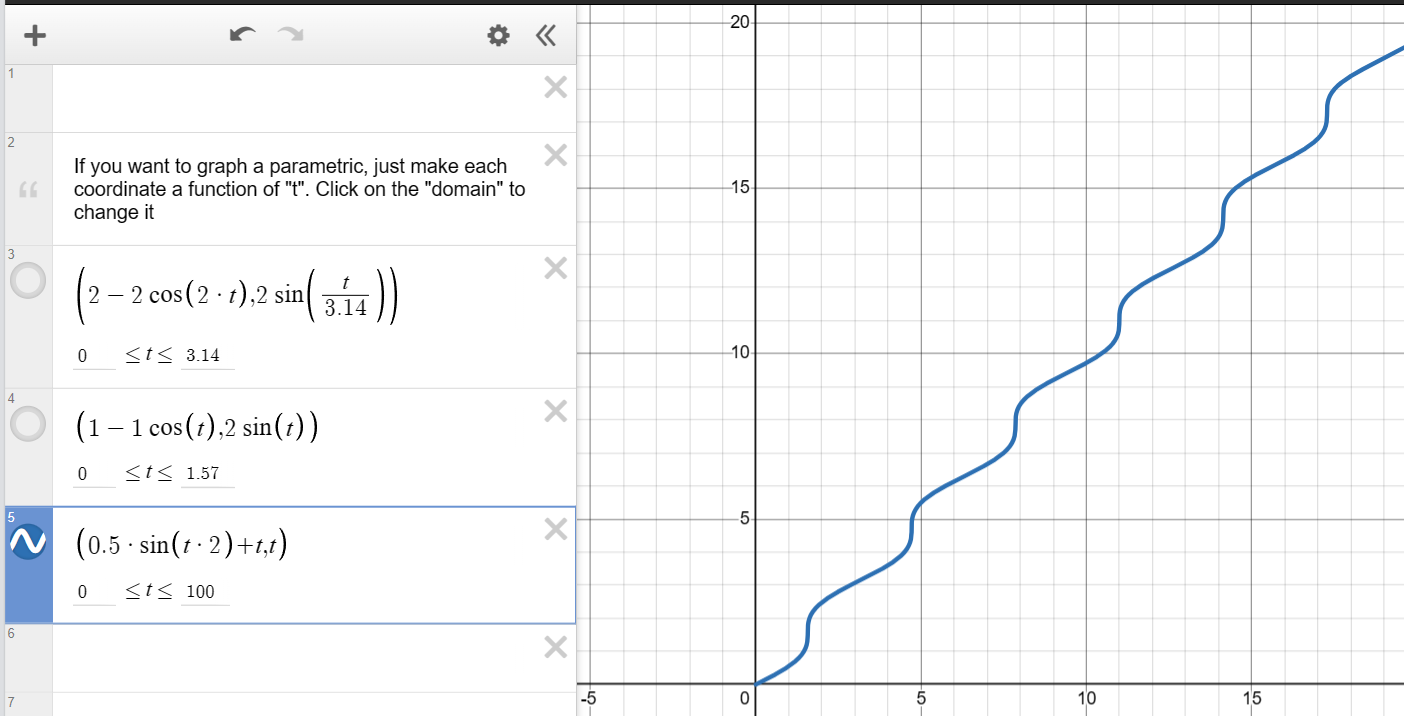

In [115]:
def MySolver(t, x, alpha, q_values, k_values):
    
    ob = x[12] - x[13] + x[14] - x[15]
       
    xd = [0.5*np.sin(2*t)+t , np.cos(2*t)+1, t, 1, 0.1 * t, 0.1, 0.5*np.sin(2*t)+t , np.cos(2*t)+1, t, 1, 0.1 * t, 0.1]
    xdd = [np.cos(2*t)+1, -2*np.sin(2*t), 1, 0, 0.1, 0,  np.cos(2*t)+1, -2*np.sin(2*t), 1, 0, 0.1, 0]
    
    z = np.zeros(12)
    
    for w in range(0, 11, 2):
        z[w] = xd[w] - x[w]

    for q in range(1, 12, 2):
        z[q] = x[q] - xdd[q-1] - alpha[q//2] * z[q-1]

    q1, q2, q3, q4, q5, q6 = q_values[0], q_values[1], q_values[2],q_values[3],q_values[4], q_values[5]
    k1, k2, k3, k4, k5, k6 = k_values[0], k_values[1], k_values[2],k_values[3],k_values[4], k_values[5]

    V1 = z[0]**2 / 2
    V3 = z[2]**2 / 2
    V2 = (V1 + z[1]**2) / 2
    V4 = (V3 + z[3]**2) / 2

    U2 = 1 / b1 * (-q1 * np.sign(z[1]) - k1 * z[1] - a1 * x[3] * x[5] - a2 * x[1]**2 - a3 * ob * x[3] + xdd[1] + (xd[1] - x[1]))
    U3 = 1 / b2 * (-q2 * np.sign(z[3]) - k2 * z[3] - a4 * x[1] * x[5] - a5 * x[3]**2 - a6 * ob * x[1] + xdd[3] + (xd[3] - x[3]))
    U4 = 1 / b3 * (-q3 * np.sign(z[5]) - k3 * z[5] - a7 * x[1] * x[5] - a8 * x[5]**2 + xdd[5] + (xd[5] - x[5]))

    U1 = m / (np.cos(x[0]) * np.cos(x[2])) * (-q6 * np.sign(z[11]) - k6 * z[11] - a11 * x[11] + xdd[11] + (xd[11] - x[11]) + g)
    Forces = np.linalg.solve(np.array([[1,1,1,1],[-d,0,d,0],[0,d,0,-d],[kdkp,-kdkp,kdkp,-kdkp]]),np.array([[U1],[U2],[U3],[U4]]))
    
    all_Forces.append(Forces.tolist())
    if U1 == 0:
        Ux, Uy = 0, 0
    else:
        Ux = m / U1 * (-q4 * np.sign(z[7]) - k4 * z[7] - a9 * x[7] + xdd[7] + (xd[7] - x[7]))
        Uy = m / U1 * (-q5 * np.sign(z[9]) - k5 * z[9] - a10 * x[9] + xdd[9] + (xd[9] - x[9]))
    
    U1_arr.append(U1)
    U2_arr.append(U2)
    U3_arr.append(U3)
    U4_arr.append(U4)
    Ux_arr.append(Ux)
    Uy_arr.append(Uy)
    
    dx1 = x[1]
    dx2 = a1 * x[3] * x[5] + a2 * (x[1]**2) + a3 * ob * x[3] + b1 * U2
    dx3 = x[3]
    dx4 = a4 * x[1] * x[5] + a5 * (x[3]**2) + a6 * ob * x[1] + b2 * U3
    dx5 = x[5]
    dx6 = a7 * x[1] * x[3] + a8 * (x[5]**2) + b3 * U4
    dx7 = x[7]
    dx8 = a9 * x[7] + (Ux * (U1 / m))
    dx9 = x[9]
    dx10 = a10 * x[9] + (Uy * (U1 / m))
    dx11 = x[11]
    dx12 = a11 * x[11] + ((np.cos(x[0]) * np.cos(x[2]) * U1) / m) - g
    dx13 = b * V1 - beta0 - beta1 * x[12] - beta2 * (x[12]**2)
    dx14 = b * V2 - beta0 - beta1 * x[13] - beta2 * (x[13]**2)
    dx15 = b * V1 - beta0 - beta1 * x[14] - beta2 * (x[14]**2)
    dx16 = b * V1 - beta0 - beta1 * x[15] - beta2 * (x[15]**2)

    return [dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8, dx9, dx10, dx11, dx12, dx13, dx14, dx15, dx16]

# Define the objective function to minimize (tracking error)
def objective(params):
    alpha = np.full(6, params[0])
    q_values = np.full(6, params[1])
    k_values = np.full(6, params[2])
    all_Forces = []
    # Call the ODE solver with current parameters
    sol = solve_ivp(MySolver, [0, 15], np.zeros(16), args=(alpha, q_values, k_values), method='RK45', t_eval=np.linspace(0, 15, 100))

    # Extract the solution
    t = sol.t
    x = sol.y.T

    # Compute the yaw error
    yaw_desired = 0.5*np.sin(2*t)+t
    yaw_obtained = x[:, 6]
    yaw_error = np.sum((yaw_desired - yaw_obtained) ** 2)

    return yaw_error

# Initial guess for parameters
initial_params = [0.0, 0.0, 0.0]
#initial_params = [0.1, 0.1, 0.1]
# Minimize the objective function
result = minimize(objective, initial_params, bounds=[(0, 1), (0, 1), (0, 1)])

# Extract the best parameters and corresponding error
best_params = result.x
best_error = result.fun

print('Best Parameters:', best_params)
print('Best Error:', best_error)

# Plot the results for visualization if needed
# Plot the results for visualization if needed
alpha = np.full(6, best_params[0])
q_values = np.full(6, best_params[1])
k_values = np.full(6, best_params[2])
all_Forces = []
sol = solve_ivp(MySolver, [0, 15], np.zeros(16), args=(alpha, q_values, k_values), method='RK45', t_eval=np.linspace(0, 15, 100))

t = sol.t
x = sol.y.T


Best Parameters: [1. 1. 1.]
Best Error: 2.0772365345800727


In [128]:
def MySolver(t, x, alpha, q_values, k_values):
    
    ob = x[12] - x[13] + x[14] - x[15]
       
    xd = [0.5*np.sin(2*t)+t , np.cos(2*t)+1, t, 1, 0.1 * t, 0.1, 0.5*np.sin(2*t)+t , np.cos(2*t)+1, t, 1, 0.1 * t, 0.1]
    xdd = [np.cos(2*t)+1, -2*np.sin(2*t), 1, 0, 0.1, 0,  np.cos(2*t)+1, -2*np.sin(2*t), 1, 0, 0.1, 0]
    
    z = np.zeros(12)
    
    for w in range(0, 11, 2):
        z[w] = xd[w] - x[w]

    for q in range(1, 12, 2):
        z[q] = x[q] - xdd[q-1] - alpha[q//2] * z[q-1]

    q1, q2, q3, q4, q5, q6 = q_values[0], q_values[1], q_values[2],q_values[3],q_values[4], q_values[5]
    k1, k2, k3, k4, k5, k6 = k_values[0], k_values[1], k_values[2],k_values[3],k_values[4], k_values[5]

    V1 = z[0]**2 / 2
    V3 = z[2]**2 / 2
    V2 = (V1 + z[1]**2) / 2
    V4 = (V3 + z[3]**2) / 2

    U2 = 1 / b1 * (-q1 * np.sign(z[1]) - k1 * z[1] - a1 * x[3] * x[5] - a2 * x[1]**2 - a3 * ob * x[3] + xdd[1] + (xd[1] - x[1]))
    U3 = 1 / b2 * (-q2 * np.sign(z[3]) - k2 * z[3] - a4 * x[1] * x[5] - a5 * x[3]**2 - a6 * ob * x[1] + xdd[3] + (xd[3] - x[3]))
    U4 = 1 / b3 * (-q3 * np.sign(z[5]) - k3 * z[5] - a7 * x[1] * x[5] - a8 * x[5]**2 + xdd[5] + (xd[5] - x[5]))

    U1 = m / (np.cos(x[0]) * np.cos(x[2])) * (-q6 * np.sign(z[11]) - k6 * z[11] - a11 * x[11] + xdd[11] + (xd[11] - x[11]) + g)
    Forces = np.linalg.solve(np.array([[1,1,1,1],[-d,0,d,0],[0,d,0,-d],[kdkp,-kdkp,kdkp,-kdkp]]),np.array([[U1],[U2],[U3],[U4]]))
    
    all_Forces.append(Forces.tolist())
    if U1 == 0:
        Ux, Uy = 0, 0
    else:
        Ux = m / U1 * (-q4 * np.sign(z[7]) - k4 * z[7] - a9 * x[7] + xdd[7] + (xd[7] - x[7]))
        Uy = m / U1 * (-q5 * np.sign(z[9]) - k5 * z[9] - a10 * x[9] + xdd[9] + (xd[9] - x[9]))
    
    U1_arr.append(U1)
    U2_arr.append(U2)
    U3_arr.append(U3)
    U4_arr.append(U4)
    Ux_arr.append(Ux)
    Uy_arr.append(Uy)
    
    dx1 = x[1]
    dx2 = a1 * x[3] * x[5] + a2 * (x[1]**2) + a3 * ob * x[3] + b1 * U2
    dx3 = x[3]
    dx4 = a4 * x[1] * x[5] + a5 * (x[3]**2) + a6 * ob * x[1] + b2 * U3
    dx5 = x[5]
    dx6 = a7 * x[1] * x[3] + a8 * (x[5]**2) + b3 * U4
    dx7 = x[7]
    dx8 = a9 * x[7] + (Ux * (U1 / m))
    dx9 = x[9]
    dx10 = a10 * x[9] + (Uy * (U1 / m))
    dx11 = x[11]
    dx12 = a11 * x[11] + ((np.cos(x[0]) * np.cos(x[2]) * U1) / m) - g
    dx13 = b * V1 - beta0 - beta1 * x[12] - beta2 * (x[12]**2)
    dx14 = b * V2 - beta0 - beta1 * x[13] - beta2 * (x[13]**2)
    dx15 = b * V1 - beta0 - beta1 * x[14] - beta2 * (x[14]**2)
    dx16 = b * V1 - beta0 - beta1 * x[15] - beta2 * (x[15]**2)

    return [dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8, dx9, dx10, dx11, dx12, dx13, dx14, dx15, dx16]

In [132]:
all_Forces = []
U1_arr =[]
U2_arr =[]
U3_arr =[]
U4_arr= []
Ux_arr =[]
Uy_arr=[]
sol = solve_ivp(MySolver, [0, 15], np.zeros(16), args=(alpha, q_values, k_values), method='RK45', t_eval=np.linspace(0, 15, 100))

t = sol.t
x = sol.y.T

## Some resultant stabilizing control laws (4 of 6)

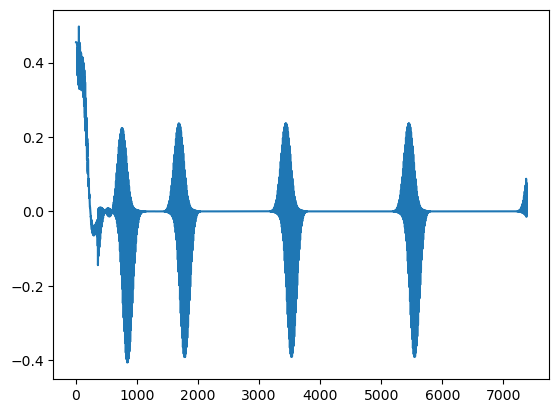

In [134]:
plt.plot(Ux_arr)

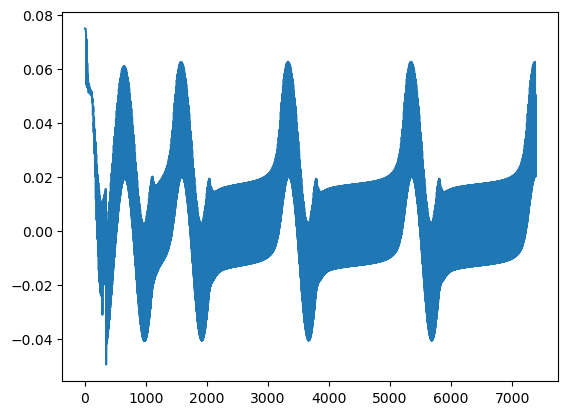

In [137]:
plt.plot(U2_arr)

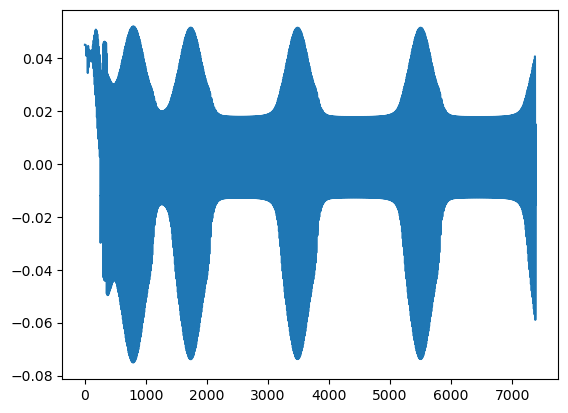

In [138]:
plt.plot(U3_arr)

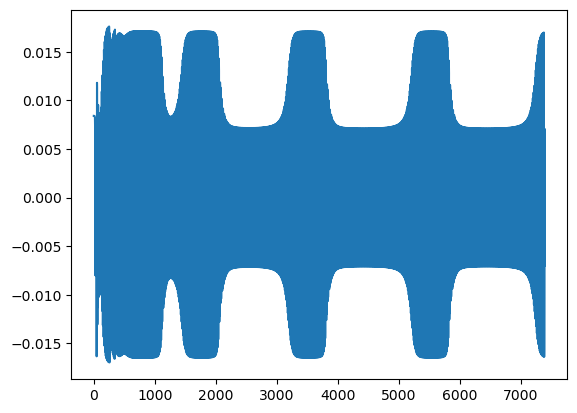

In [139]:
plt.plot(U4_arr)

## Analyzing the estimated trajectory

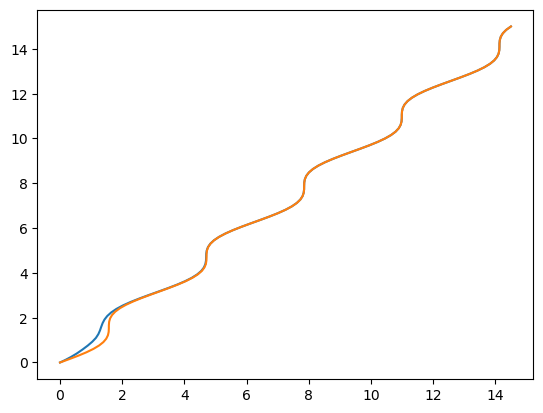

In [84]:
plt.plot(x[:,6],x[:,8])
t = np.linspace(0,15,100)
plt.plot(0.5*np.sin(2*t)+t,t)

In [85]:
y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12 = [],[],[],[],  [],[],[],[], [],[],[],[]
tt = np.linspace(0,15,100)
for i in range(100):
    t=tt[i]
    y1.append(0.5*np.sin(2*t)+t)
    y2.append(np.cos(2*t)+1)
    y3.append(t)
    y4.append(1)
    y5.append(0.1*t)
    y6.append(0.1)
    y7.append(0.5*np.sin(2*t) + t)
    y8.append(np.cos(2*t)+1)
    y9.append(t)
    y10.append(1)
    y11.append(0.1*t)
    y12.append(0.1)

Text(0.5, 1.0, 'Z dot')

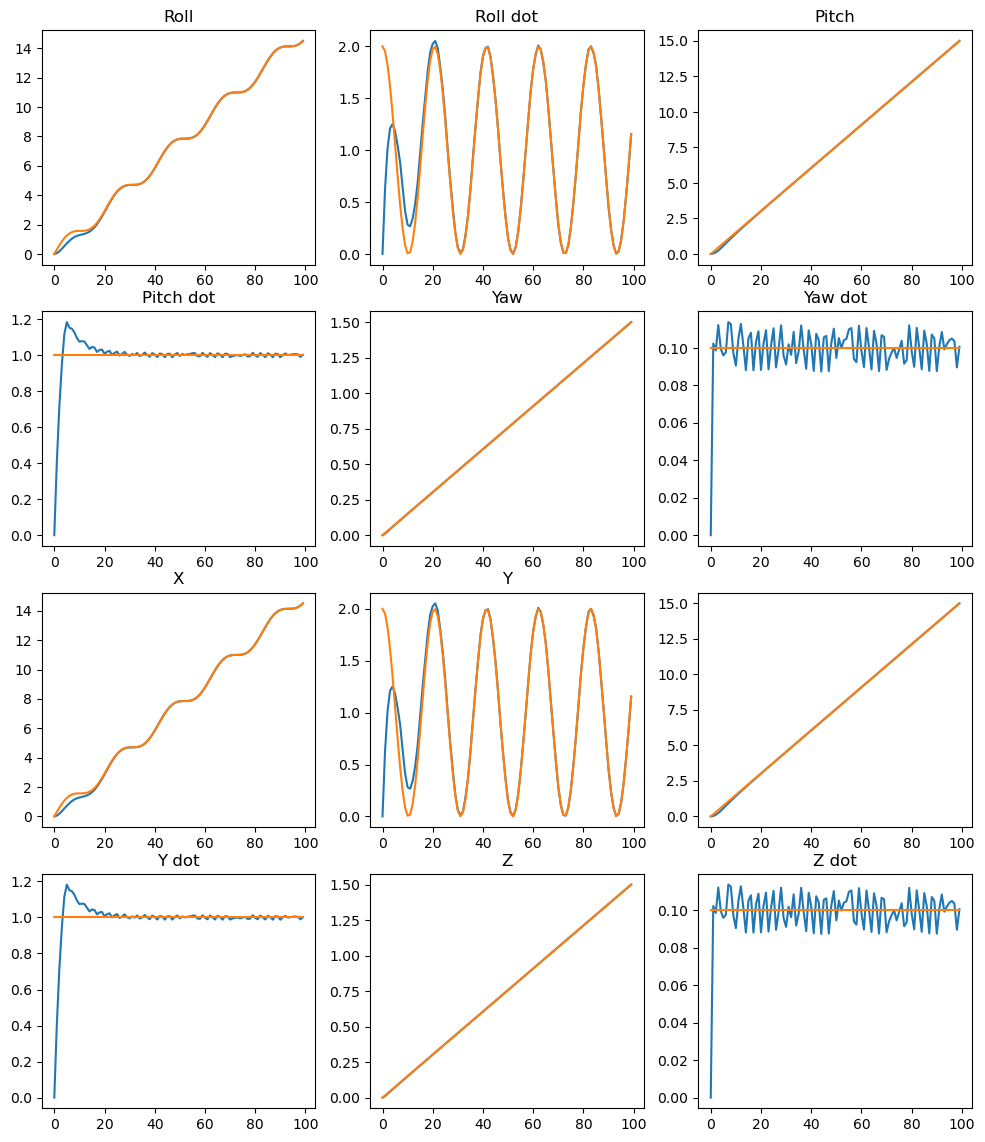

In [92]:
f, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4, 3, figsize = (12,14))
ax1.plot(x[:,0])
ax1.plot(y1)        
ax1.set_title('Roll')

ax2.plot(x[:,1])
ax2.plot(y2)
ax2.set_title('Roll dot')

ax3.plot(x[:,2])
ax3.plot( y3)
ax3.set_title('Pitch')

ax4.plot(x[:,3])
ax4.plot(y4)
ax4.set_title('Pitch dot')

ax5.plot(x[:,4])
ax5.plot( y5)
ax5.set_title('Yaw')

ax6.plot(x[:,5])
ax6.plot( y6)
ax6.set_title('Yaw dot')

ax7.plot(x[:,6])
ax7.plot( y7)
ax7.set_title('X')

ax8.plot(x[:,7])
ax8.plot( y8)
ax8.set_title('X dot')

ax9.plot(x[:,8])
ax9.plot(y9)
ax8.set_title('Y')

ax10.plot(x[:,9])
ax10.plot( y10)
ax10.set_title('Y dot')

ax11.plot(x[:,10])
ax11.plot(y11)
ax11.set_title('Z')

ax12.plot(x[:,11])
ax12.plot(y12)
ax12.set_title('Z dot')

Text(0.5, 1.0, 'Z dot Error')

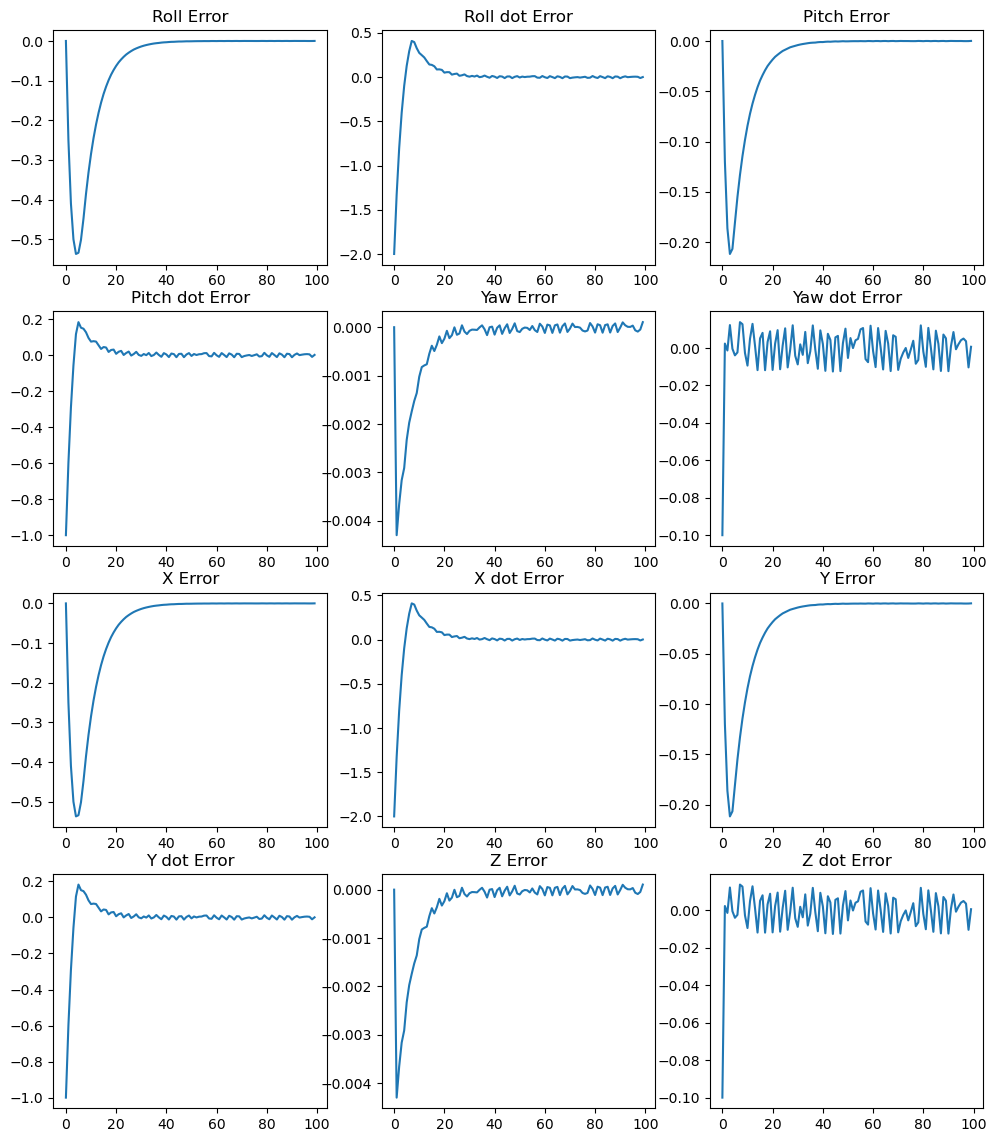

In [91]:
f, ((ax1, ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12)) = plt.subplots(4, 3, figsize = (12,14))
ax1.plot(x[:,0] -y1)       
ax1.set_title('Roll Error')

ax2.plot(x[:,1]-y2)
ax2.set_title('Roll dot Error')

ax3.plot(x[:,2]-y3)
ax3.set_title('Pitch Error')

ax4.plot(x[:,3]-y4)
ax4.set_title('Pitch dot Error')

ax5.plot(x[:,4]-y5)
ax5.set_title('Yaw Error')

ax6.plot(x[:,5]-y6)

ax6.set_title('Yaw dot Error')

ax7.plot(x[:,6]-y7)

ax7.set_title('X Error')

ax8.plot(x[:,7]-y8)

ax8.set_title('X dot Error')

ax9.plot(x[:,8]-y9)

ax9.set_title('Y Error')

ax10.plot(x[:,9]-y10)

ax10.set_title('Y dot Error')

ax11.plot(x[:,10]-y11)
ax11.set_title('Z Error')

ax12.plot(x[:,11]-y12)

ax12.set_title('Z dot Error')

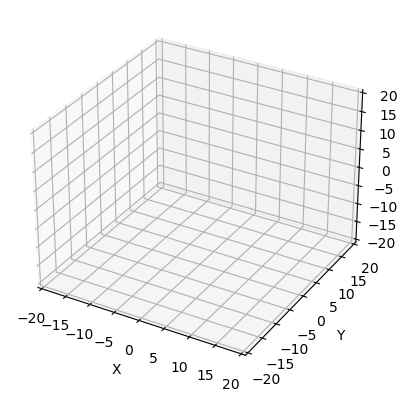

In [140]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def update(num,data,line):
    
    #print(data[:2, :num])
    line.set_data(x[:num,6],x[:num,8])
    line.set_3d_properties(x[:num,10])

def gen(n):
    phi = 0
    while phi < 2*np.pi:
        yield np.array([np.cos(phi), np.sin(phi), phi])
        phi += 2*np.pi/n
N = 200
data = np.array(list(gen(N))).T
line, = ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1])

# Setting the axes properties
ax.set_xlim3d([-20.0, 20.0])
ax.set_xlabel('X')

ax.set_ylim3d([-20.0, 20.0])
ax.set_ylabel('Y')

ax.set_zlim3d([-20.0, 20.0])
ax.set_zlabel('Z')

ani = animation.FuncAnimation(fig, update, N, fargs=(data,line),interval=10000/N, blit=False)
#plt.show()
#ani.save('matplot003.gif', writer='imagemagick')
from IPython.display import HTML, display

#!!!!Delete comment to see the graph
#display(HTML(ani.to_jshtml()))

# Estimation of a straight-line traj with the curves (not so good)

Or it is possible to estimate with curves:

In [68]:
array_needed_points = [(0,0), (2,0),(2,1),(3,1),(3,3)]
array_points = [(2,1),(1,2)]  #differs  4-2, 3-1 and 2-0,1-0

In [69]:
def MySolver(t, x, alpha, q_values, k_values):
    curr_num=1
    ob = x[12] - x[13] + x[14] - x[15]
    x0 = 0
    y0 = 0
    if (t>curr_num*1.57):
        curr_num =2
        x0 = 2
        y0 = 1
        
    t_prev = 1.57 * (curr_num-1)
        
    R1 = array_points[curr_num - 1][0]
    R2 = array_points[curr_num - 1][1]
       
    xd = [R1*(1 -np.cos(t-t_prev)), R1*np.sin(t-t_prev), R2*np.sin(t-t_prev), R2*np.cos(t-t_prev), 0.1 * t, 0.1, x0 + R1*(1 -np.cos(t-t_prev)), R1*np.sin(t-t_prev),y0+ R2*np.sin(t-t_prev), R2*np.cos(t-t_prev), 0.1 * t, 0.1]
    xdd = [R1*np.sin(t-t_prev), R1*np.cos(t-t_prev), R2*np.cos(t-t_prev),-R2*np.sin(t-t_prev), 0.1, 0, R1*np.sin(t-t_prev), R1*np.cos(t-t_prev), R2*np.cos(t-t_prev),-R2*np.sin(t-t_prev), 0.1, 0]
    z = np.zeros(12)
    
    for w in range(0, 11, 2):
        z[w] = xd[w] - x[w]

    for q in range(1, 12, 2):
        z[q] = x[q] - xdd[q-1] - alpha[q//2] * z[q-1]

    q1, q2, q3, q4, q5, q6 = q_values[0], q_values[1], q_values[2],q_values[3],q_values[4], q_values[5]
    k1, k2, k3, k4, k5, k6 = k_values[0], k_values[1], k_values[2],k_values[3],k_values[4], k_values[5]

    V1 = z[0]**2 / 2
    V3 = z[2]**2 / 2
    V2 = (V1 + z[1]**2) / 2
    V4 = (V3 + z[3]**2) / 2

    U2 = 1 / b1 * (-q1 * np.sign(z[1]) - k1 * z[1] - a1 * x[3] * x[5] - a2 * x[1]**2 - a3 * ob * x[3] + xdd[1] + (xd[1] - x[1]))
    U3 = 1 / b2 * (-q2 * np.sign(z[3]) - k2 * z[3] - a4 * x[1] * x[5] - a5 * x[3]**2 - a6 * ob * x[1] + xdd[3] + (xd[3] - x[3]))
    U4 = 1 / b3 * (-q3 * np.sign(z[5]) - k3 * z[5] - a7 * x[1] * x[5] - a8 * x[5]**2 + xdd[5] + (xd[5] - x[5]))

    U1 = m / (np.cos(x[0]) * np.cos(x[2])) * (-q6 * np.sign(z[11]) - k6 * z[11] - a11 * x[11] + xdd[11] + (xd[11] - x[11]) + g)
    #Forces = np.linalg.solve(np.array([[1,1,1,1],[-d,0,d,0],[0,d,0,-d],[kdkp,-kdkp,kdkp,-kdkp]]),np.array([[U1],[U2],[U3],[U4]]))
    
    #all_Forces.append(Forces.tolist())
    if U1 == 0:
        Ux, Uy = 0, 0
    else:
        Ux = m / U1 * (-q4 * np.sign(z[7]) - k4 * z[7] - a9 * x[7] + xdd[7] + (xd[7] - x[7]))
        Uy = m / U1 * (-q5 * np.sign(z[9]) - k5 * z[9] - a10 * x[9] + xdd[9] + (xd[9] - x[9]))

    dx1 = x[1]
    dx2 = a1 * x[3] * x[5] + a2 * (x[1]**2) + a3 * ob * x[3] + b1 * U2
    dx3 = x[3]
    dx4 = a4 * x[1] * x[5] + a5 * (x[3]**2) + a6 * ob * x[1] + b2 * U3
    dx5 = x[5]
    dx6 = a7 * x[1] * x[3] + a8 * (x[5]**2) + b3 * U4
    dx7 = x[7]
    dx8 = a9 * x[7] + (Ux * (U1 / m))
    dx9 = x[9]
    dx10 = a10 * x[9] + (Uy * (U1 / m))
    dx11 = x[11]
    dx12 = a11 * x[11] + ((np.cos(x[0]) * np.cos(x[2]) * U1) / m) - g
    dx13 = b * V1 - beta0 - beta1 * x[12] - beta2 * (x[12]**2)
    dx14 = b * V2 - beta0 - beta1 * x[13] - beta2 * (x[13]**2)
    dx15 = b * V1 - beta0 - beta1 * x[14] - beta2 * (x[14]**2)
    dx16 = b * V1 - beta0 - beta1 * x[15] - beta2 * (x[15]**2)

    return [dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8, dx9, dx10, dx11, dx12, dx13, dx14, dx15, dx16]

# Define the objective function to minimize (tracking error)
def objective(params):
    alpha = np.full(6, params[0])
    q_values = np.full(6, params[1])
    k_values = np.full(6, params[2])

    # Call the ODE solver with current parameters
    sol = solve_ivp(MySolver, [0, 1.57*2], np.zeros(16), args=(alpha, q_values, k_values), method='RK45', t_eval=np.linspace(0, 1.57*2, 100))

    # Extract the solution
    t = sol.t
    x = sol.y.T
    
    # Compute the yaw error
    R = 1
    yaw_desired =[]
    tt = np.linspace(0,1.57*2,100)
    y0 = 0
    for i in range(100):
        if tt[i]>1.57:
            y0 = 1
        yaw_desired.append( y0 + 1*np.sin(tt[i] - (Kk(t[i]) * 1.57)))
    yaw_desired = np.asarray(yaw_desired)
    
    yaw_obtained = x[:,8]
    
    
    yaw_error = np.sum((yaw_desired - yaw_obtained) ** 2)

    return yaw_error
def Rr(t):
    if t>1.57:
        R=2
    else: 
        R=1
    return R
def Kk(t):
    if t<1.57:
        k=0
    else: 
        k=1
    return k
# Initial guess for parameters
initial_params = [0.0, 0.0, 0.0]
#initial_params = [0.1, 0.1, 0.1]
# Minimize the objective function
result = minimize(objective, initial_params, bounds=[(0, 1), (0, 1), (0, 1)])

# Extract the best parameters and corresponding error
best_params = result.x
best_error = result.fun

print('Best Parameters:', best_params)
print('Best Error:', best_error)

# Plot the results for visualization if needed
# Plot the results for visualization if needed
alpha = np.full(6, best_params[0])
q_values = np.full(6, best_params[1])
k_values = np.full(6, best_params[2])

sol = solve_ivp(MySolver, [0, 1.57*2], np.zeros(16), args=(alpha, q_values, k_values), method='RK45', t_eval=np.linspace(0, 1.57*2, 100))

t = sol.t
x = sol.y.T



Best Parameters: [0.64582093 0.5078607  0.83902293]
Best Error: 5.343668569305696


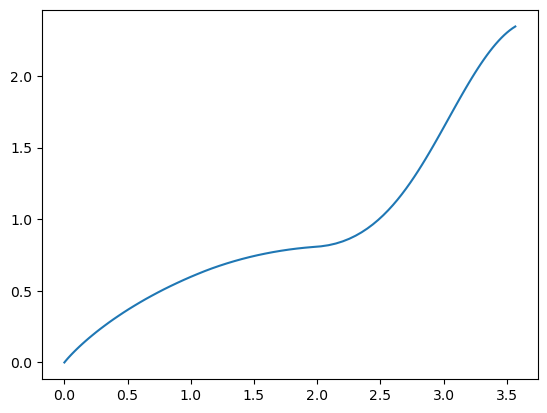

In [70]:
plt.plot(x[:,6],x[:,8])

But it is difficult here to provide nice trajectory for angles too. And the difference between the course is big at the nodes. So it will work badly 

# Estimation with the straight lines 

I also tried just straight lines:

In [93]:
def MyTrajectory(Nodes):
    Traj =[]
    Traj_dot =[]
    prev = [0,0]
    prev_Node = [0,0]
    tim_ind = 0
    for i in range(len(Nodes)):
        Comparison = [np.abs(Nodes[i][0] - prev_Node[0]),np.abs(Nodes[i][1] - prev_Node[1])]
        maxpos = Comparison.index(max(Comparison))
        
        Distance = Comparison[maxpos]
        t_window = Distance/0.15
        
        for p in range(int(t_window+1)):
            Traj.append([prev[0] + 0.15 * (maxpos == 0)*np.sign(Nodes[i][0] - prev_Node[0]), prev[1] + 0.15* (maxpos == 1)*np.sign(Nodes[i][1] - prev_Node[1]) ])
            Traj_dot.append([0.15 * (maxpos == 0)*np.sign(Nodes[i][0] - prev_Node[0]), 0.15* (maxpos == 1)*np.sign(Nodes[i][1] - prev_Node[1])])
            prev = Traj[-1]
            
            tim_ind +=0.15
        prev_Node = Nodes[i]
    return(Traj,Traj_dot)

In [110]:
Traj,Traj_dot = MyTrajectory([[0,1], [-2,1],[-2,3]])

In [104]:
np.asarray(Traj).shape

(35, 2)

In [105]:
def MySolverStraight(t, x, alpha, q_values, k_values):
    tim = int(t)
    xd = [Traj[tim][0], Traj_dot[tim][0], Traj[tim][1], Traj_dot[tim][1], 0.1 * t, 0.1, Traj[tim][0], Traj_dot[tim][0], Traj[tim][1], Traj_dot[tim][1], 0.1 * t, 0.1]
    xdd = [Traj_dot[tim][0], 0, Traj_dot[tim][1], 0, 0.1 , 0,  Traj_dot[tim][0], 0, Traj_dot[tim][1], 0, 0.1 , 0]
    z = np.zeros(12)
    ob = x[12] - x[13] + x[14] - x[15]
    for w in range(0, 11, 2):
        z[w] = xd[w] - x[w]

    for q in range(1, 12, 2):
        z[q] = x[q] - xdd[q-1] - alpha[q//2] * z[q-1]

    q1, q2, q3, q4, q5, q6 = q_values[0], q_values[1], q_values[2],q_values[3],q_values[4], q_values[5]
    k1, k2, k3, k4, k5, k6 = k_values[0], k_values[1], k_values[2],k_values[3],k_values[4], k_values[5]

    V1 = z[0]**2 / 2
    V3 = z[2]**2 / 2
    V2 = (V1 + z[1]**2) / 2
    V4 = (V3 + z[3]**2) / 2

    U2 = 1 / b1 * (-q1 * np.sign(z[1]) - k1 * z[1] - a1 * x[3] * x[5] - a2 * x[1]**2 - a3 * ob * x[3] + xdd[1] + (xd[1] - x[1]))
    U3 = 1 / b2 * (-q2 * np.sign(z[3]) - k2 * z[3] - a4 * x[1] * x[5] - a5 * x[3]**2 - a6 * ob * x[1] + xdd[3] + (xd[3] - x[3]))
    U4 = 1 / b3 * (-q3 * np.sign(z[5]) - k3 * z[5] - a7 * x[1] * x[5] - a8 * x[5]**2 + xdd[5] + (xd[5] - x[5]))

    U1 = m / (np.cos(x[0]) * np.cos(x[2])) * (-q6 * np.sign(z[11]) - k6 * z[11] - a11 * x[11] + xdd[11] + (xd[11] - x[11]) + g)
    #Forces = np.linalg.solve(np.array([[1,1,1,1],[-d,0,d,0],[0,d,0,-d],[kdkp,-kdkp,kdkp,-kdkp]]),np.array([[U1],[U2],[U3],[U4]]))
    
    #all_Forces.append(Forces.tolist())
    if U1 == 0:
        Ux, Uy = 0, 0
    else:
        Ux = m / U1 * (-q4 * np.sign(z[7]) - k4 * z[7] - a9 * x[7] + xdd[7] + (xd[7] - x[7]))
        Uy = m / U1 * (-q5 * np.sign(z[9]) - k5 * z[9] - a10 * x[9] + xdd[9] + (xd[9] - x[9]))

    dx1 = x[1]
    dx2 = a1 * x[3] * x[5] + a2 * (x[1]**2) + a3 * ob * x[3] + b1 * U2
    dx3 = x[3]
    dx4 = a4 * x[1] * x[5] + a5 * (x[3]**2) + a6 * ob * x[1] + b2 * U3
    dx5 = x[5]
    dx6 = a7 * x[1] * x[3] + a8 * (x[5]**2) + b3 * U4
    dx7 = x[7]
    dx8 = a9 * x[7] + (Ux * (U1 / m))
    dx9 = x[9]
    dx10 = a10 * x[9] + (Uy * (U1 / m))
    dx11 = x[11]
    dx12 = a11 * x[11] + ((np.cos(x[0]) * np.cos(x[2]) * U1) / m) - g
    dx13 = b * V1 - beta0 - beta1 * x[12] - beta2 * (x[12]**2)
    dx14 = b * V2 - beta0 - beta1 * x[13] - beta2 * (x[13]**2)
    dx15 = b * V1 - beta0 - beta1 * x[14] - beta2 * (x[14]**2)
    dx16 = b * V1 - beta0 - beta1 * x[15] - beta2 * (x[15]**2)

    return [dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8, dx9, dx10, dx11, dx12, dx13, dx14, dx15, dx16]

def objective(params):
    alpha = np.full(6, params[0])
    q_values = np.full(6, params[1])
    k_values = np.full(6, params[2])
    
    sol = solve_ivp(MySolverStraight, [0, 33], np.zeros(16), args=(alpha, q_values, k_values), method='RK45', t_eval=np.linspace(0, 33, 220))
    
    t = sol.t
    x = sol.y.T
    
    yaw_desired = 0.1 * t
    yaw_obtained = x[:, 11]
    yaw_error = np.sum((yaw_desired - yaw_obtained) ** 2)

    return yaw_error

# Initial guess for parameters
initial_params = [0.0, 0.0, 0.0]
#initial_params = [0.1, 0.1, 0.1]
# Minimize the objective function
result = minimize(objective, initial_params, bounds=[(0, 1), (0, 1), (0, 1)])

# Extract the best parameters and corresponding error
best_params = result.x
best_error = result.fun

print('Best Parameters:', best_params)
print('Best Error:', best_error)

# Plot the results for visualization if needed
# Plot the results for visualization if needed
alpha = np.full(6, best_params[0])
q_values = np.full(6, best_params[1])
k_values = np.full(6, best_params[2])

sol = solve_ivp(MySolverStraight, [0,33], np.zeros(16), args=(alpha, q_values, k_values), method='RK45', t_eval=np.linspace(0, 33, 220))

t = sol.t
x = sol.y.T


Best Parameters: [0.         0.00445217 0.00073863]
Best Error: 729.9721422606463


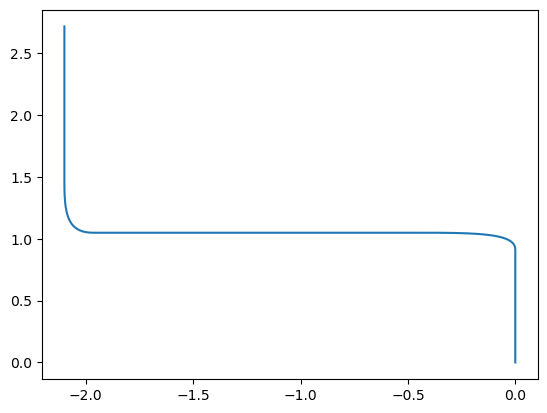

In [106]:
plt.plot(x[:,6],x[:,8])

But the error is too big. Not correct to make this way

# Communication with Unity

In [ ]:
import socket
import random
from time import sleep

def send_XYZRPY(i):
    s = socket.socket()          
              
    # connect to the server on local computer 
    s.connect(('192.168.56.1', 1755))
    s.send((
        str(int(x[i][6]*100)) + ","+ 
        str(int(x[i][8]*100)) + ","+ 
        str(int(x[i][10]*100)) + ","+ 
        str(int(x[i][0]*100)) + ","+ 
        str(int(x[i][2]*100)) + ","+ 
        str(int(int(x[i][4]*100)))).encode())
    s.close()

for i in range(100):
    send_XYZRPY(i)
    sleep(1)

### *Also I can add the analysis of different optimization methods but I think its enough here